# [Draft] A strike slip fault underneath topography.

## Mathematical background
Note that much of the discussion here parallels the discussion in [the section on solving topographic problems with TDEs](../tdes/sa_tdes.md).

Last time we solved for the displacement and stress given slip on an infinitely long strike slip fault. This time, we'll make the problem more interesting (and a bit harder!) by adding in a free surface. First, we'll replicate classical solutions for the surface displacement on a half-space given slip on a fault. Then, we'll add in a topographic free surface and have some fun!

Let's start with the integral equation for displacement resulting from slip on a crack/fault and displacement and traction on another arbitrary surface:

\begin{equation}
u(\mathbf{p}) = \int_{H} G(\mathbf{p}, \mathbf{q}) t(\mathbf{q}) d\mathbf{q} + \int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} +\int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q}
\end{equation}

where $H$ is the surface, $F$ is the fault, $t$ is traction, $u$ is displacement and $s$ is slip. Immediately, we can see that, for a free surface, the first term is zero because the traction is zero, so we are left with:

\begin{equation}
u(\mathbf{p}) = \int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} +\int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q}
\end{equation}

So, this equation says that we can calculate displacement anywhere if we know displacement on $H$ and slip on $F$. But, we don't know the displacement on $H$! So, step one is going to be solving for the unknown displacement on the surface $H$. To do that, intuitively, we need to reduce from two unknowns to one unknown in this equation. Currently we have both the unknown displacement on $H$ and the unknown displacement at an arbitrary point in the volume, $u(\mathbf{p})$. To solve this, we can take the limit as $\mathbf{p} \to H$

\begin{equation}
\lim_{\mathbf{p} \to H} \bigg[ u(\mathbf{p}) = \int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} + \int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q} \bigg] ~~~~~~ \forall \mathbf{p} \in H
\end{equation}

In the limit, the free term gains a factor of $\frac{1}{2}$ such that :

\begin{equation}
\frac{1}{2}u(\mathbf{p}) = \int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} + \int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q} ~~~~~~ \forall \mathbf{p} \in H
\end{equation}

beacuse $u$ is now only evaluated on the boundary, this equation is solvable for $u$ given $s$. Re-arrange to put the unknowns on the left hand side: 
\begin{equation}
\frac{1}{2}u(\mathbf{p}) - \int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} = \int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q}
\end{equation}

Note that the integrals are now being evaluated in their singular limits. Previously, we have only evaluated nearly singular integrals that arise when the observation point is very close to the source surface. Fortunately, QBX works just as well in the limit to the boundary and as a result, nothing about our integration procedures will need to change. 

Once discretized using our QBX-based quadrature tools from the previous sections, this will look like:
\begin{equation}
\frac{1}{2}\mathbf{Iu} + \mathbf{Au} = \mathbf{Bs}
\end{equation}

where $\mathbf{A}$ and $\mathbf{B}$ are matrices representing the action of the integral terms on surface displacement and fault slip respectively. $\mathbf{I}$ is the identity matrix.

## Solving for surface displacement

For the first section, we're going to reproduce analytical solutions for the displacement due to slip on a buried fault under a half space. That solution {cite:p}`segallEarthquakeVolcanoDeformation2010` is:
\begin{equation}
u_z = \frac{-s}{2\pi}\bigg[\tan^{-1}(\frac{x}{y + d_1}) - \tan^{-1}(\frac{x}{y - d_1}) - \tan^{-1}(\frac{x}{y + d_2}) + \tan^{-1}(\frac{x}{y - d_2}) \bigg]
\end{equation}

To start with the numerical implementation, we'll define two surfaces. Using the same convention as in previous sections, we'll return a tuple of `(x, y, normal_x, normal_y, jacobian)`. The `fault_fnc` function will define a fault extending from 0.5 units depth to 1.5 units depth and the `flat_fnc` function will define a free surface extending from -25 to 25 units along the x axis. 

Note that while we're trying to approximate a free surface, we won't attempt to actually have an infinite surface here. It will turn out that 25 units in both directions is enough to get a very good match with the analytical solution. If we truly wanted to model an infinite surface numerically, it would be possible to do so with something like [Gauss-Laguerre quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Laguerre_quadrature) and I would enjoy trying that out some day! However, the goal here isn't to actually model an infinite domain. The Earth is not infinite! Instead, the goal is simply to demonstrate that our numerical methods work on an analytically tractable problem before moving on to problems that are analytically intractable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from common import (
    gauss_rule,
    double_layer_matrix,
    qbx_choose_centers,
    qbx_expand_matrix,
    qbx_eval_matrix,
    interaction_matrix,
    interior_eval,
)

%config InlineBackend.figure_format='retina'

fault_depth = 0.5


def fault_fnc(q):
    return 0 * q, q - 1 - fault_depth, -np.ones_like(q), 0 * q, np.ones_like(q)


surf_L = 25


def flat_fnc(q):
    return surf_L * q, 0 * q, 0 * q, np.ones_like(q), np.full_like(q, surf_L)

And we'll define a slip function here on the unit interval. The slip is set up to taper to zero on both ends of the interval so that we don't accidentally introduce stress singularities into the model. If the slip at the end of the interval were non-zero, that would result in discontinuities in displacement and infinite strain and stresses. This is another place where we are making slightly different choices than the analytical solution which *does* include stress singularities.

Conceptually, the $\mathbf{A}$ matrix is the interaction of the flat free surface with itself. Let's build that matrix first using the QBX tools from the last two sections. As mentioned, we won't need to do anything different for evaluating these integrals in the limit of the observation point being on the boundary. 

The code will be a little bit different because we need to construct a matrix for arbitrary displacement fields whereas previously we already had a specific displacement field in mind.

In [2]:
qr_flat = gauss_rule(2000)
flat = flat_fnc(qr_flat[0])

qbx_p = 5
# Following the previous examples.
# 1) Choose the expansion centers off the boundary.
qbx_center_x, qbx_center_y, qbx_r = qbx_choose_centers(flat, qr_flat, direction=1)
# 2) Build a matrix that takes an input displacement
qbx_expand_flat = qbx_expand_matrix(
    double_layer_matrix, flat, qr_flat, qbx_center_x, qbx_center_y, qbx_r, qbx_p=qbx_p
)
# 3) Evaluate the QBX expansions for observation points on the boundary.
# The first two arguments here are the x and y coordinates on the boundary.
qbx_eval_flat = qbx_eval_matrix(
    flat[0][None, :], flat[1][None, :], qbx_center_x, qbx_center_y, qbx_p=qbx_p
)[0]
# 4) Multiply the expansion and evaluation matrices to get the full boundary integral matrix.
A = -np.real(np.sum(qbx_eval_flat[:, None, :, None] * qbx_expand_flat, axis=2))[:, 0, :]

For the $\mathbf{B}$ term, we don't need to bother with QBX and can just directly perform the boundary integrals. This is because the observation points are sufficiently far away from the source fault surface that there are no nearly-singular or singular integrals. Note that we apply unit slip along the entire fault. In many models, this would be problematic because the fault tip displacement discontinuities introduce stress singularities into the model. However, for the sake of comparing with the analytical solution, we can accept the stress singularities for now. And because we are not evaluating stress near the fault, we don't need to worry about the issue. 

For the same reason, we don't need many quadrature points for the fault. We can achieve machine precision with just 25 quadrature points.

In [3]:
qr_fault = gauss_rule(25)
fault = fault_fnc(qr_fault[0])

B = double_layer_matrix(fault, qr_fault, flat[0], flat[1])[:, 0, :]
slip = np.ones_like(qr_fault[0])
v = B.dot(slip)

And remembering the third identity matrix term, we form the full left hand side as $\mathbf{A} + \frac{1}{2}\mathbf{I}$. Then, solve the linear system for the unknown displacements!

In [4]:
lhs = A + 0.5 * np.eye(A.shape[0])
surf_disp = np.linalg.solve(lhs, v)

And let's compare with the analytical solution in the figures below. The match is quite good. Looking at the error figure, a couple things stand out:
1. The tips of the free surface have very high relative errors. This is simply due to the difference between a finite free surface and the infinite free surface in the analytical solution.
2. The error is extremely low everywhere else. We are seeing 5 to 7 digits of accuracy!
3. The error is highest near the fault, almost 100x higher than further from the fault. The discretization error is likely to be highest where the gradients in the solution are largest. The gradients are largest near the fault.

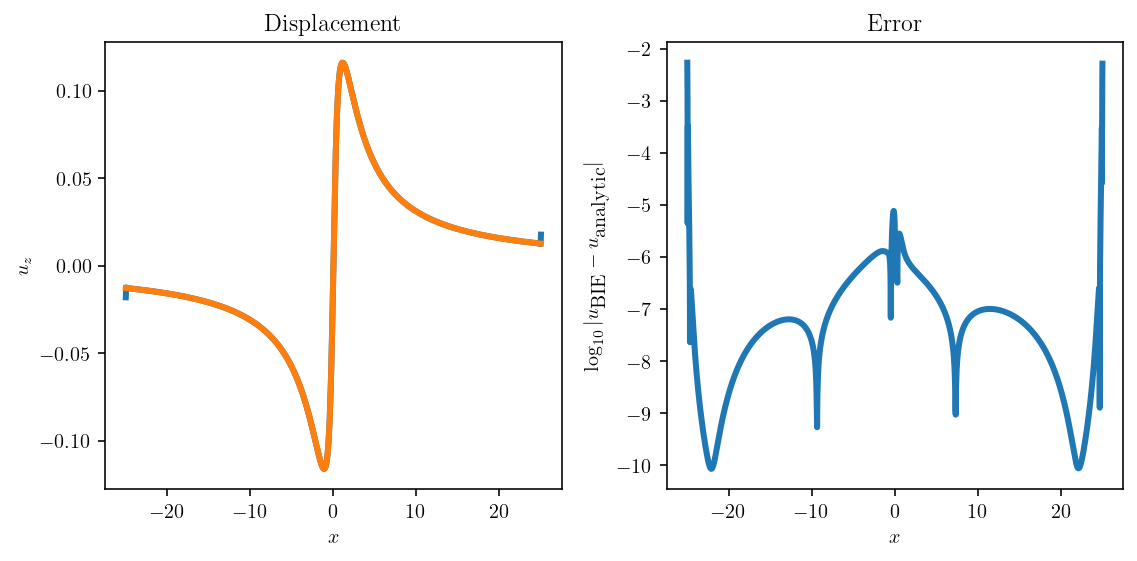

In [5]:
s = 0.5
analytical = (
    -s
    / (2 * np.pi)
    * (
        np.arctan(flat[0] / (flat[1] + 2.5))
        - np.arctan(flat[0] / (flat[1] - 2.5))
        - np.arctan(flat[0] / (flat[1] + 0.5))
        + np.arctan(flat[0] / (flat[1] - 0.5))
    )
)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(flat[0], surf_disp)
plt.plot(flat[0], analytical)
plt.xlabel("$x$")
plt.ylabel("$u_z$")
plt.title("Displacement")

plt.subplot(1, 2, 2)
plt.plot(flat[0], np.log10(np.abs(surf_disp - analytical)))
plt.xlabel("$x$")
plt.ylabel("$\log_{10}|u_{\\textrm{BIE}} - u_{\\textrm{analytic}}|$")
plt.title("Error")
plt.tight_layout()
plt.show()

## Evaluating interior displacement

In [6]:
nobs = 100
zoomx = [-2.5, 2.5]
zoomy = [-4.5, 0.5]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)

Now that we have the surface displacement, we can return to the integral form of the interior displacement: 

\begin{equation}
u(\mathbf{p}) = \int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} +\int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q}
\end{equation}

and, using QBX via the `interior_eval` function from the last section, directly calculate the two integrals on the right hand side. The integral over $H$ will be `disp_flat` and the integral over $F$ will be `disp_fault`.

In [7]:
disp_flat = interior_eval(
    double_layer_matrix,
    flat,
    qr_flat,
    surf_disp,
    obsx.flatten(),
    obsy.flatten(),
    offset_mult=3.0,
    kappa=3,
    qbx_p=5,
).reshape(obsx.shape)

disp_fault = interior_eval(
    double_layer_matrix,
    fault,
    qr_fault,
    slip,
    obsx.flatten(),
    obsy.flatten(),
    offset_mult=3.0,
    kappa=3,
    qbx_p=5,
).reshape(obsx.shape)

disp_full = disp_flat + disp_fault

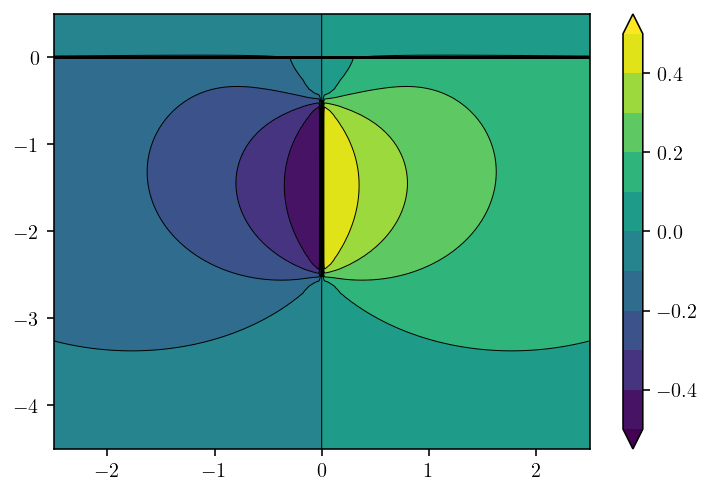

In [8]:
levels = np.linspace(-0.5, 0.5, 11)
cntf = plt.contourf(obsx, obsy, disp_full, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    disp_full,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(flat[0], flat[1], "k-", linewidth=1.5)
plt.plot(fault[0], fault[1], "k-", linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.show()

## Adding topography

In the rest of this section, we'll replicate the calculation above except for a free surface with topography. The calculations will be identical except for the construction of the surface itself. 

I'll first define a parametric line with a Gaussian hill in the middle. `sympy` will be helpful here so that we can symbolically compute the normal derivatives and the norm of the transformation from $t$ to $(x,y)$.

In [9]:
import sympy as sp

sym_t = sp.symbols("t")
sym_x = surf_L * sym_t
sym_y = sp.exp(-(sym_t ** 2) * 200) * sp.Rational(1.5) - sp.Rational(1.5)

sp.Eq(sp.var("x,y"), sp.Tuple(sym_x, sym_y))

Eq((x, y), (25*t, -3/2 + 3*exp(-200*t**2)/2))

I'll write a generic function here that can accept a parameterization of a curve and return the tuple of symbolic `(x, y, normal_x, normal_y, norm)`.

In [10]:
def symbolic_surface(t, x, y):
    dxdt = sp.diff(x, t)
    dydt = sp.diff(y, t)

    ddt_norm = sp.simplify(sp.sqrt(dxdt ** 2 + dydt ** 2))
    dxdt /= ddt_norm
    dydt /= ddt_norm
    return x, y, -dydt, dxdt, ddt_norm


sym_topo = symbolic_surface(sym_t, sym_x, sym_y)

Here are the symbolic normal vector and norm of the transformation.

In [11]:
sp.Eq(sp.var("\\vec{n}"), sp.Tuple(sym_topo[2], sym_topo[3]))

Eq(\vec{n}, (24*t*exp(-200*t**2)/sqrt(576*t**2*exp(-400*t**2) + 1), 1/sqrt(576*t**2*exp(-400*t**2) + 1)))

In [12]:
sp.Eq(sp.var("\|T\|_2"), sym_topo[4])

Eq(\|T\|_2, 25*sqrt(576*t**2*exp(-400*t**2) + 1))

And the next two cells will convert from this symbolic surface representation into a numerical surface representation by evaluating at the specified Gaussian quadrature points.

Then I'll plot a quick diagram of the mesh and the surface normals.

In [13]:
def symbolic_eval(t, tvals, exprs):
    out = []
    for e in exprs:
        out.append(sp.lambdify(t, e, "numpy")(tvals))
    return out

In [14]:
qr_topo = gauss_rule(800)
topo = symbolic_eval(sym_t, qr_topo[0], sym_topo)

(-3.5, 1.5)

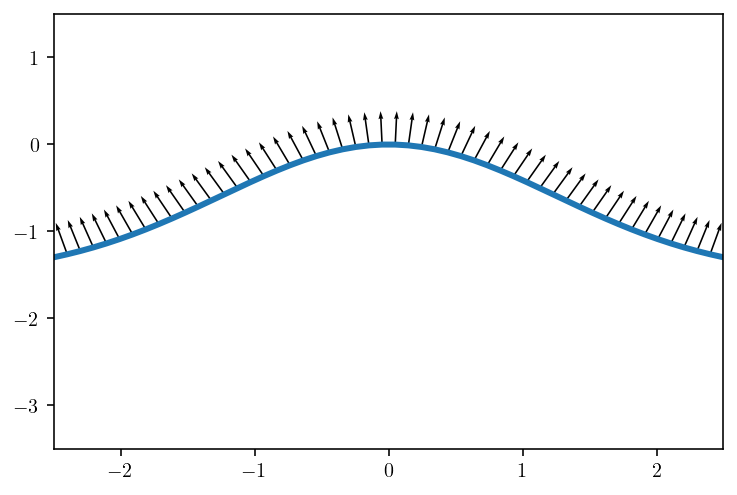

In [15]:
plt.plot(topo[0], topo[1])
plt.quiver(topo[0], topo[1], topo[2], topo[3], scale=20)
plt.xlim([-2.5, 2.5])
plt.ylim([-3.5, 1.5])

And let's follow the same procedure as before, we'll solve for the surface displacement. The shape doesn't look that different from before, but the peak surface displacements near the fault are a bit higher.

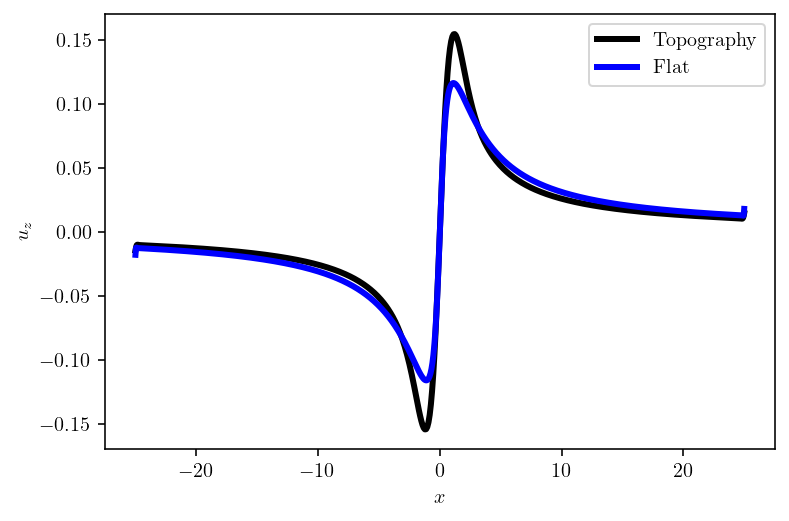

In [16]:
qbx_p = 5
# 1) Choose the expansion centers off the boundary.
qbx_center_x, qbx_center_y, qbx_r = qbx_choose_centers(topo, qr_topo, direction=1)
# 2) Build a matrix that takes an input displacement
qbx_expand_topo = qbx_expand_matrix(
    double_layer_matrix, topo, qr_topo, qbx_center_x, qbx_center_y, qbx_r, qbx_p=qbx_p
)
# 3) Evaluate the QBX expansions for observation points on the boundary.
# The first two arguments here are the x and y coordinates on the boundary.
qbx_eval_topo = qbx_eval_matrix(
    topo[0][None, :], topo[1][None, :], qbx_center_x, qbx_center_y, qbx_p=qbx_p
)[0]
# 4) Multiply the expansion and evaluation matrices to get the full boundary integral matrix.
A = -np.real(np.sum(qbx_eval_topo[:, None, :, None] * qbx_expand_topo, axis=2))[:, 0, :]

B = double_layer_matrix(fault, qr_fault, topo[0], topo[1])[:, 0, :]
v = B.dot(slip)
lhs = A + 0.5 * np.eye(A.shape[0])
surf_disp_topo = np.linalg.solve(lhs, v)

plt.plot(topo[0], surf_disp_topo, "k-", label="Topography")
plt.plot(flat[0], surf_disp, "b-", label="Flat")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$u_z$")
plt.show()

## Interior displacement under topography

In [17]:
nobs = 200
zoomx = [-2.5, 2.5]
zoomy = [-3.5, 1.5]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)

And finally, we'll plot the displacement in the volume underneath the topography. Just like the in the flat case. To show the effect of both integral terms, I've separated out the topography integral term and the fault integral term in the plots.

In [18]:
disp_topo = interior_eval(
    double_layer_matrix,
    topo,
    qr_topo,
    surf_disp_topo,
    obsx.flatten(),
    obsy.flatten(),
    offset_mult=3.0,
    kappa=3,
    qbx_p=5,
).reshape(obsx.shape)

disp_fault = interior_eval(
    double_layer_matrix,
    fault,
    qr_fault,
    slip,
    obsx.flatten(),
    obsy.flatten(),
    offset_mult=3.0,
    kappa=3,
    qbx_p=5,
).reshape(obsx.shape)

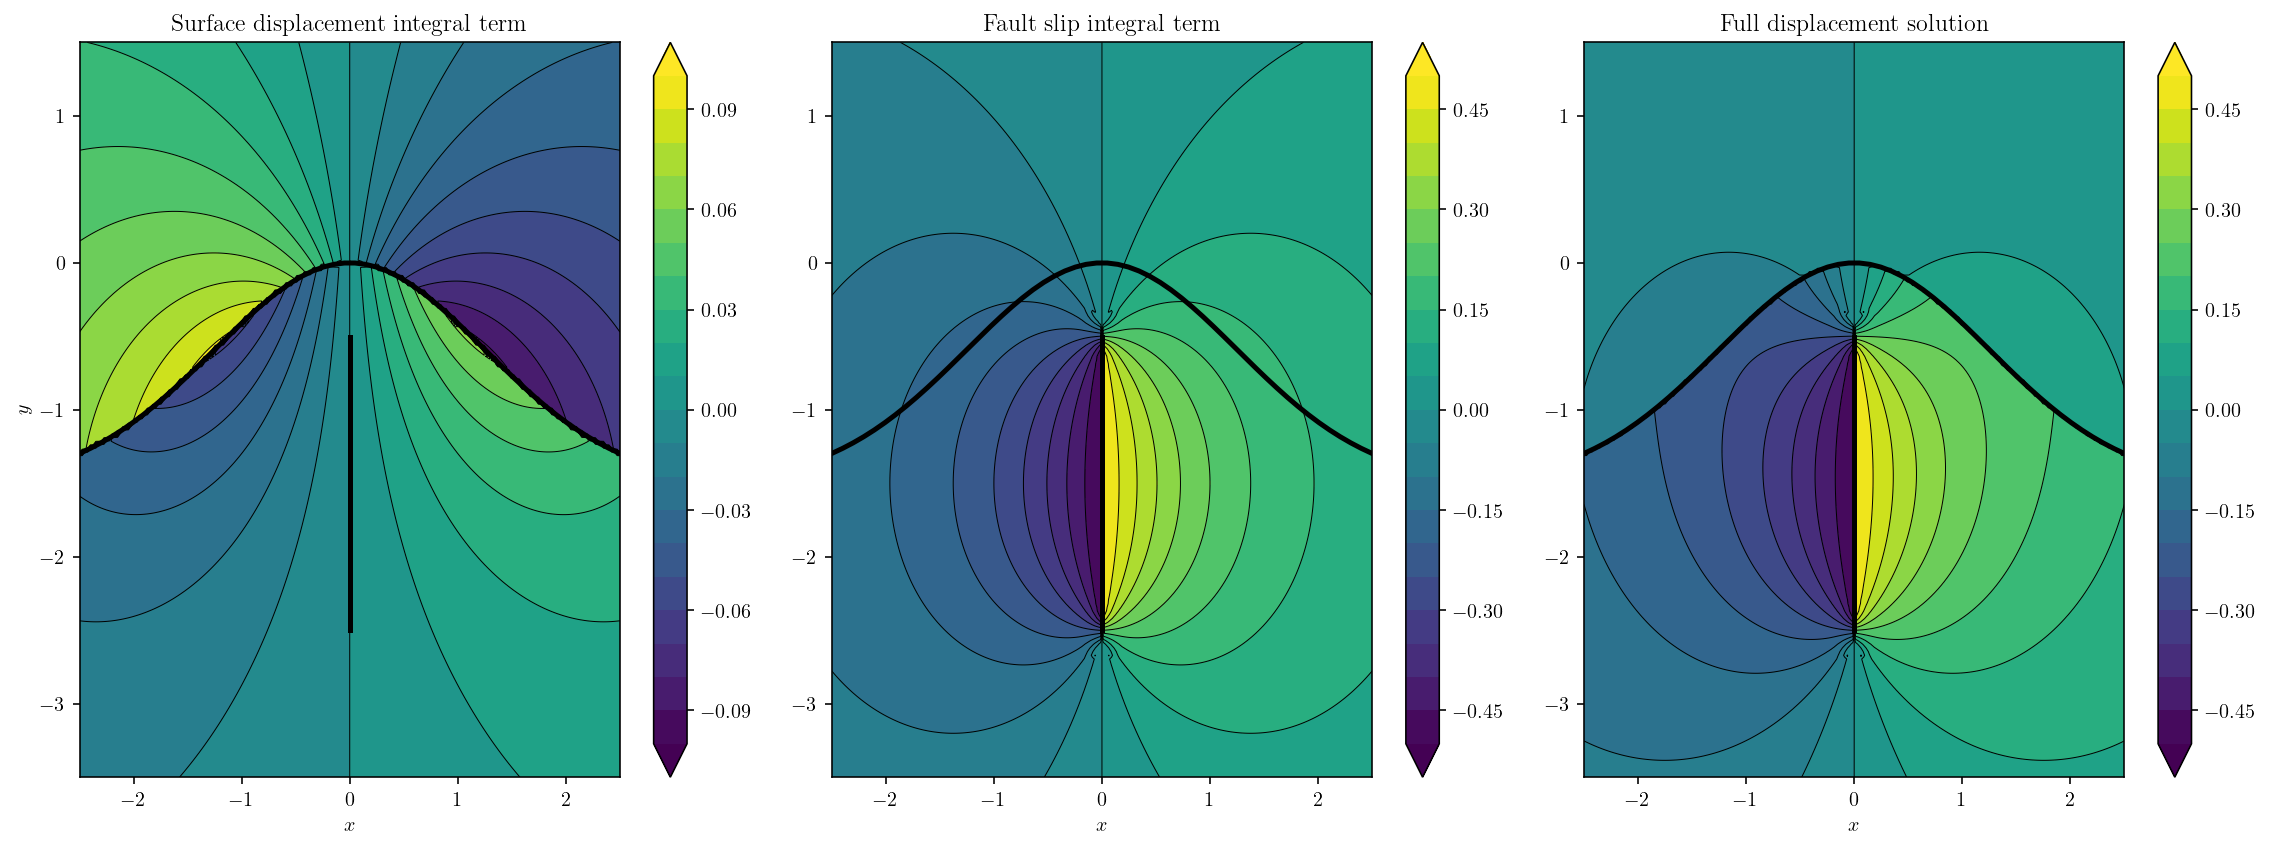

In [19]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
levels = np.linspace(-0.1, 0.1, 21)
cntf = plt.contourf(obsx, obsy, disp_topo, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    disp_topo,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(topo[0], topo[1], "k-", linewidth=2.5)
plt.plot(fault[0], fault[1], "k-", linewidth=2.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Surface displacement integral term")

plt.subplot(1, 3, 2)
levels = np.linspace(-0.5, 0.5, 21)
cntf = plt.contourf(obsx, obsy, disp_fault, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    disp_fault,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(topo[0], topo[1], "k-", linewidth=2.5)
plt.plot(fault[0], fault[1], "k-", linewidth=2.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.xlabel("$x$")
plt.title("Fault slip integral term")

plt.subplot(1, 3, 3)
levels = np.linspace(-0.5, 0.5, 21)
cntf = plt.contourf(obsx, obsy, disp_topo + disp_fault, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    disp_topo + disp_fault,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(topo[0], topo[1], "k-", linewidth=2.5)
plt.plot(fault[0], fault[1], "k-", linewidth=2.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.xlabel("$x$")
plt.title("Full displacement solution")

plt.tight_layout()
plt.show()